In [2]:
%reload_ext autoreload
%autoreload 2

import pickle
from constants import *
from models import generate_stream_spray, generate_stream_streak

import jax
import jax.numpy as jnp
import functools
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.size'] = 18

from utils import *
from priors import *
from mock_data import *

from models import *

In [3]:
N = 50

seed_chi2, chi2 = [], []
seed_chi, chi = [], []
for i in tqdm(range(N), leave=True):

    with open(f"./MockStreams/seed{i}/dict_data.pkl", "rb") as f:
        dict_data = pickle.load(f)

    params = dict_data['params']

    q = get_q(params[2], params[3], params[4])
    theta_stream, xv_stream = generate_stream_streak(params[:2] + (q, ) + params[2:],  seed=111, n_steps=500, n_particles=1000)
    count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])

    diff = abs(dict_data['r_bin'] - r_bin)[dict_data['count'] > 100]
    bias = (dict_data['r_bin'] - r_bin)[dict_data['count'] > 100]

    chi2.extend((diff / dict_data['r_bin'][dict_data['count'] > 100]))
    chi.extend((bias / dict_data['r_bin'][dict_data['count'] > 100]))

    q = get_q(params[2], params[3], params[4])
    theta_stream, xv_stream = generate_stream_spray(params[:2] + (q, ) + params[2:],  seed=111+1, n_steps=500, n_particles=10000)
    count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])

    diff = abs(dict_data['r_bin'] - r_bin)[dict_data['count'] > 100]
    bias = (dict_data['r_bin'] - r_bin)[dict_data['count'] > 100]

    seed_chi2.extend((diff / dict_data['r_bin'][dict_data['count'] > 100]))
    seed_chi.extend((bias / dict_data['r_bin'][dict_data['count'] > 100]))

seed_chi2 = jnp.array(seed_chi2)
seed_chi = jnp.array(seed_chi)
chi2 = jnp.array(chi2)
chi = jnp.array(chi)


100%|██████████| 50/50 [01:16<00:00,  1.52s/it]


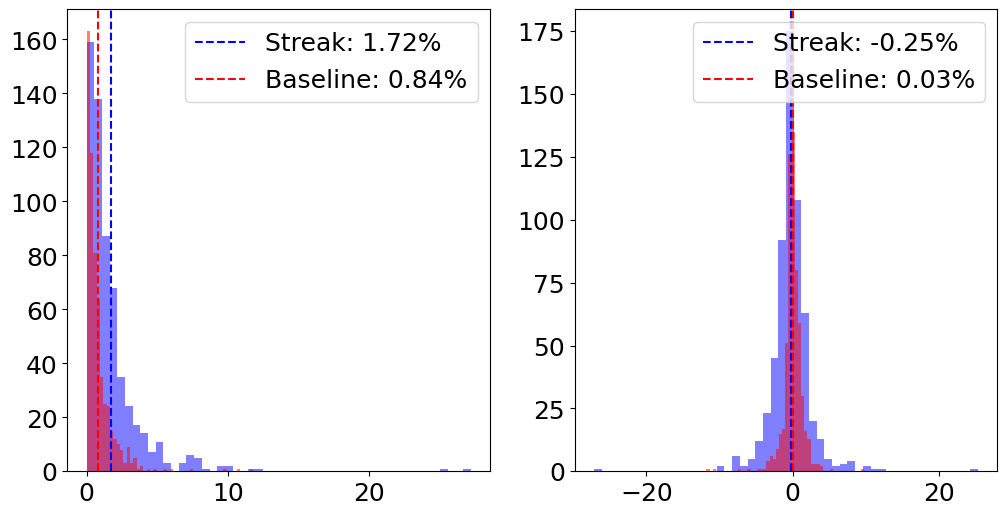

In [4]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(100*chi2, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_chi2, bins=50, alpha=0.5, color='r')
plt.axvline(np.mean(100*chi2), color='b', linestyle='--', label=f'Streak: {np.mean(100*chi2):.2f}%')
plt.axvline(np.mean(100*seed_chi2), color='r', linestyle='--', label=f'Baseline: {np.mean(100*seed_chi2):.2f}%')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.hist(100*chi, bins=50, alpha=0.5, color='b')
plt.hist(100*seed_chi, bins=50, alpha=0.5, color='r')
plt.axvline(np.mean(100*chi), color='b', linestyle='--', label=f'Streak: {np.mean(100*chi):.2f}%')
plt.axvline(np.mean(100*seed_chi), color='r', linestyle='--', label=f'Baseline: {np.mean(100*seed_chi):.2f}%')
plt.legend(loc='upper right')